In [1]:
using Gadfly
using Vec, LinearAlgebra
using GridWorldPathFollowing

In [2]:
start_pt = VecE2(0.0,0.0)
start_time = 0.0
# action_sequence = [DOWN,RIGHT,UP,RIGHT,RIGHT,RIGHT,DOWN,DOWN,LEFT,UP,LEFT,DOWN,LEFT,LEFT]
action_sequence = [RIGHT,UP,RIGHT]
cell_width = 1.0
transition_time = 2.0
grid_path = construct_grid_world_path(start_pt,start_time,
    action_sequence,cell_width,transition_time)

traj = construct_trajectory(grid_path)
verify(traj)

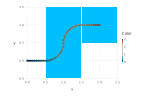

In [3]:
Δt = 0.01
t_range = get_start_time(traj):Δt:get_end_time(traj)
t_color_range = get_start_time(traj):(10*Δt):get_end_time(traj)
pad = 0.01
plot(
    layer(
        x=[get_position(traj,t).x for t in t_range],
        y=[get_position(traj,t).y for t in t_range],
        Geom.path,
        Theme(default_color="black")
        ),
    layer(
        x=[get_position(traj,t).x for t in t_color_range],
        y=[get_position(traj,t).y for t in t_color_range],
        color=[get_dist(traj,t) for t in t_color_range],
        Geom.point
        ),
    layer(
        xmin=map(w->w.pt.x - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        xmax=map(w->w.pt.x + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        ymin=map(w->w.pt.y - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        ymax=map(w->w.pt.y + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        Geom.rect
    ),
    Coord.cartesian(fixed=true)
)

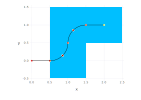

In [4]:
Δt = 0.01
t_range = get_start_time(traj):Δt:get_end_time(traj)
t_color_range = get_start_time(traj):(10*Δt):get_end_time(traj)
pad = 0.01
plot(
    layer(
        x=[get_position(traj,t).x for t in t_range],
        y=[get_position(traj,t).y for t in t_range],
        Geom.path,
        Theme(default_color="black")
        ),
    layer(
        x=[get_start_pt(seg).x for seg in traj.segments],
        y=[get_start_pt(seg).y for seg in traj.segments],
        Geom.point,
        Theme(default_color="red")
        ),
    layer(
        x=[get_end_pt(seg).x for seg in traj.segments],
        y=[get_end_pt(seg).y for seg in traj.segments],
        Geom.point,
        Theme(default_color="yellow")
        ),
    layer(
        xmin=map(w->w.pt.x - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        xmax=map(w->w.pt.x + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        ymin=map(w->w.pt.y - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        ymax=map(w->w.pt.y + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        Geom.rect
    ),
    Coord.cartesian(fixed=true)
)

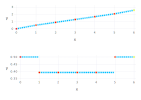

In [5]:
start_times = [get_start_time(seg) for seg in traj.segments]
final_times = [get_end_time(seg) for seg in traj.segments]
plot1 = plot(
    layer(x=start_times,y=[get_dist(traj,t) for t in start_times],Theme(default_color="red")),
    layer(x=final_times,y=[get_dist(traj,t) for t in final_times],Theme(default_color="yellow")),
    layer(x=collect(t_color_range),y=[get_dist(traj,t) for t in t_color_range])
)
plot2 = plot(
    layer(x=start_times,y=[norm(get_vel(traj,t)) for t in start_times],Theme(default_color="red")),
    layer(x=final_times,y=[norm(get_vel(traj,t)) for t in final_times],Theme(default_color="yellow")),
    layer(x=collect(t_color_range),y=[norm(get_vel(traj,t)) for t in t_color_range])
)
vstack(plot1,plot2)

# Optimize Velocity Profile
We apply a polynomial acceleration command in each time window

In [6]:
using Convex, ECOS, SCS

In [7]:
# t = 0.5
# n = 3
# a = ones(n) # coefficients
# Polynomial basis vector
tv(t,n) = [t^j for j in 0:n]
# a(t) = a[1] + a[2]*t + a[3]*t^2 + ... + a[n]*t^(n-1)
#      = a'*tv
# Differentiation
Dmat(n) = vcat([[i*(i == j-1) for j in 1:n+1]' for i in 1:n+1]...)
# d/dt a(t) = a[2] + 2*a[3]*t + ... + (n-1)*a[n]*t^(n-2)
#           = (Dmat*a)'*tv
# Integration from 0 to t
Imat(n,d=1) = vcat([[(1/prod([k for k in j:j+d-1]))*(i == j+1) for j in 1:n+1]' for i in 2:n+2]...);
# ∫ a(t) = a[1]*t + (1/2)*a[2]*t^2 + ... + (1/n)*a[n]*t^n
#        = (Imat*a)'*t*tv

In [15]:
N = length(traj.segments)
d = [get_length(seg) for seg in traj.segments]
cd = cumsum(d)
t = [[get_start_time(seg) for seg in traj.segments]..., get_end_time(traj)]
dt = diff(t)
v0 = 0.0
vT = 0.0
s0 = 0.0
sT = get_length(traj)

n = 1 # order of acceleration polynomial: a[i] = a_0 + a_1*t + a_2*t^2 + ... a_n*t^n
m = 8 # num accel windows (m per seg, equally spaced in time)
# each trajectory has a m-phase acceleration profile
a = [Variable(m) for t in 1:N] # accel cmd coefficients 
v = [Variable(m+1) for t in 1:N]
s = [Variable(m+1) for t in 1:N]

constraints = [
#     [a[i] <= 15.0 for i in 1:N]...,
#     [a[i] >= -15.0 for i in 1:N]...,
    v[1][1] == v0,    # initial conditions
    v[end][end] == vT,  # final conditions
    [v[i] >= 0.0 for i in 1:N]...,
    [v[i][end] == v[i+1][1] for i in 1:N-1]...,
    [v[i][j+1] == v[i][j] + a[i][j]*(dt[i]/m) for i in 1:N for j in 1:m]...,# dynamics
    s[1][1] == s0,
    # s[end][end] == sT,
    [s[i][end] == cd[i] for i in 1:N]...,
    [s[i][end] == s[i+1][1] for i in 1:N-1]...,
    [s[i][j+1] == s[i][j] + v[i][j]*dt[i]/m + (1/2)*a[i][j]*(dt[i]/m)^2 for i in 1:N for j in 1:m]...,
]

problem = minimize(sum([sumsquares(a[i]) for i in 1:N]),constraints);

In [16]:
solve!(problem, ECOSSolver(verbose=false))
@show problem.status;

problem.status = :Optimal


In [29]:
accel = vcat([a[i].value[:] for i in 1:N]...)
vel = [vcat([v[i].value[1:end-1] for i in 1:N]...)..., v[end].value[end]]
pos = [vcat([s[i].value[1:end-1] for i in 1:N]...)..., s[end].value[end]];
t_vec = [0, vcat([t[i] .+ (dt[i]/m)*collect(1:m) for i in 1:N]...)...];

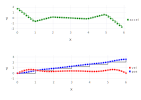

In [35]:

vstack(
    plot(
        layer(x=t_vec[1:end-1],y=accel,Theme(default_color="green")),
        layer(x=t_vec[1:end-1],y=accel,Geom.step,Theme(default_color="green")),
        Guide.manual_color_key("",["accel"],["green"])
    ),
    plot(
        layer(x=t_vec,y=vel,Theme(default_color="red")),
        layer(x=t_vec,y=vel,Geom.step,Theme(default_color="red")),
        
        layer(x=t_vec,y=pos,Theme(default_color="blue")),
        layer(x=t_vec,y=pos,Geom.step,Theme(default_color="blue")),

        layer(x = t,y = [0, cd...],Geom.step,Theme(default_color="black")),
        Guide.manual_color_key("",["vel", "pos"],["red","blue"])
    )
)